In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Plot accuracy graph wrt to x, y (z = metric)
def plotAccuracy3d(x, y, z, xlabel='Convolution layers', ylabel='Fully connected layers', zlabel='Accuracy'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca(projection='3d')
    ax.view_init(50, 35)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.contour3D(x, y, z, 50, cmap='binary')

def train(conv_layer_num, fc_layer_num, learning_rate=0.01, batch_size=4,
          kernel_size=3, activation=F.relu, batch_normalization=False, num_epochs = 3, momentum=0,
          optimizer_func=1, loss_threshold=0, debug_steps=2000):

  image_dim = 32

  transform = transforms.Compose([
                                  #transforms.Resize(size=(image_dim, image_dim)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])

  # CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
  train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)

  test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True)

  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

  classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  class ConvNet(nn.Module):
      def __init__(self):
          super(ConvNet, self).__init__()

          self.pool = nn.MaxPool2d(2, 2)

          # initialize convolution layer list
          self.conv = nn.ModuleList()

          #######################################################################
          channel_inc = 100
          #######################################################################

          # initialize batch norm 2d list if applicable
          self.batch_norm2d = []
          if batch_normalization:
            self.batch_norm2d = nn.ModuleList()
          
          # build conv and batch norm layers
          input_size = 3
          output_size = channel_inc
          self.image_size = image_dim
          for i in range(conv_layer_num):
            self.conv.append(nn.Conv2d(input_size, output_size, kernel_size))
            if batch_normalization and i % 2 == 0:
              self.batch_norm2d.append(nn.BatchNorm2d(output_size))
            input_size = output_size
            output_size = (i+2)*channel_inc
            self.image_size -= (kernel_size - 1)

            # we will apply maxpool of size (2,2) when i == 2 so we need to half the image size
            if i == 2:
              self.image_size //= 2


          # initialize fully connected layer list
          self.fc = nn.ModuleList()
          self.number_of_channels =  input_size
          # We will apply another maxpool of (2,2) after all convolutional layers
          self.image_size //= 2

          #######################################################################
          fully_connected_layer_size = 100
          #######################################################################

          # initialize batch norm 1d list if applicable
          self.batch_norm1d = []
          if batch_normalization:
            self.batch_norm1d = nn.ModuleList()

          # build fc and batch norm layers
          self.fc.append(nn.Linear(self.number_of_channels*self.image_size*self.image_size, fully_connected_layer_size))
          if batch_normalization:
              self.batch_norm1d.append(nn.BatchNorm1d(fully_connected_layer_size))

          input_size = fully_connected_layer_size
          output_size = 2*fully_connected_layer_size
          for i in range(1, fc_layer_num-1):
            self.fc.append(nn.Linear(input_size, output_size))
            if batch_normalization and i % 2 == 0 and i != fc_layer_num-2:
              self.batch_norm1d.append(nn.BatchNorm1d(output_size))
            input_size = output_size
            output_size = fully_connected_layer_size  * (i+2)
          
          self.fc.append(nn.Linear(input_size, 10))


      def forward(self, x):
          # -> n, 3, 32, 32
          for i in range(conv_layer_num):
            x = activation(self.conv[i](x))
            if i == 2:
              x = self.pool(x)
            if batch_normalization and i % 2 == 0:
              x = self.batch_norm2d[i//2](x)

          x = self.pool(x)
          x = x.view(-1, self.number_of_channels*self.image_size*self.image_size)

          for i in range(fc_layer_num-1):
            x = F.relu(self.fc[i](x))
            if batch_normalization and i % 2 == 0 and i != fc_layer_num-2:
              x = self.batch_norm1d[i//2](x)
          x = self.fc[-1](x)                       # -> n, 10
          
          return x


  model = ConvNet().to(device)

  criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
  if optimizer_func == 2:
    optimizer = torch.optim.Adadelta(model.parameters())

  t0 = time.time()
  n_total_steps = len(train_loader)

  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):
          # origin shape: [batch_size, 3, 32, 32] = 4, 3, 1024
          images = images.to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          if (i+1) % debug_steps == 0:
              print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
          
          if loss_threshold != 0 and loss.item() < loss_threshold:
              print(f'\nMin loss threshold reached. Stopping at epoch: {epoch}')
              break

      if loss_threshold != 0 and loss.item() < loss_threshold:
          print(f'\nMin loss threshold reached. Stopping at epoch: {epoch}')
          break

  print('Finished Training')
  PATH = './cnn.pth'
  torch.save(model.state_dict(), PATH)

  with torch.no_grad():
      n_correct = 0
      n_samples = 0
      n_class_correct = [0 for i in range(10)]
      n_class_samples = [0 for i in range(10)]
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          # max returns (value ,index)
          _, predicted = torch.max(outputs, 1)
          n_samples += labels.size(0)
          n_correct += (predicted == labels).sum().item()
          
          for i in range(batch_size):
              label = labels[i]
              pred = predicted[i]
              if (label == pred):
                  n_class_correct[label] += 1
              n_class_samples[label] += 1

      acc = 100.0 * n_correct / n_samples
      print(f'Accuracy of the network: {acc} %')

      '''for i in range(10):
          acc1 = 100.0 * n_class_correct[i] / n_class_samples[i]
          print(f'Accuracy of {classes[i]}: {acc1} %')'''
  ttime = int(time.time() - t0)
  return acc, ttime

In [ ]:
# 1. number of convolution layers vs number of fully connected layers vs accuracy
# conv_layer_nums = [2,3,4,5,6]
# fc_layer_nums = [2,3,4,5,6]
# dummies to save time
conv_layer_nums = [2]
fc_layer_nums = [2]
def cl_vs_fcl_vs_accuracy():
    accuracy = []
    training_time = []
    for i in range(len(conv_layer_nums)):
        temp_acc = []
        temp_time = []
        for j in range(len(fc_layer_nums)):
            print(conv_layer_nums[i], fc_layer_nums[j])
            acc, ttime = train(conv_layer_nums[i], fc_layer_nums[j])
            temp_acc.append(acc)
            temp_time.append(ttime)
            print(acc, ttime)
        accuracy.append(temp_acc)
        training_time.append(temp_time)
        

    print(accuracy, training_time)
    return accuracy, training_time
  
accuracy, training_time = cl_vs_fcl_vs_accuracy()

2 2
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/3], Step [2000/12500], Loss: 1.3041
Epoch [1/3], Step [4000/12500], Loss: 1.3261
Epoch [1/3], Step [6000/12500], Loss: 1.3056
Epoch [1/3], Step [8000/12500], Loss: 1.6362
Epoch [1/3], Step [10000/12500], Loss: 1.9642
Epoch [1/3], Step [12000/12500], Loss: 1.7896
Epoch [2/3], Step [2000/12500], Loss: 2.2006
Epoch [2/3], Step [4000/12500], Loss: 0.9275
Epoch [2/3], Step [6000/12500], Loss: 2.6820
Epoch [2/3], Step [8000/12500], Loss: 2.5170
Epoch [2/3], Step [10000/12500], Loss: 0.2820
Epoch [2/3], Step [12000/12500], Loss: 1.2337
Epoch [3/3], Step [2000/12500], Loss: 0.9086
Epoch [3/3], Step [4000/12500], Loss: 0.9107
Epoch [3/3], Step [6000/12500], Loss: 1.4956
Epoch [3/3], Step [8000/12500], Loss: 1.4082
Epoch [3/3], Step [10000/12500], Loss: 1.1164
Epoch [3/3], Step [12000/12500], Loss: 1.7277
Finished Training
Accuracy of the network: 56.99 %
56.99 88
[[56.99]] [[88]]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


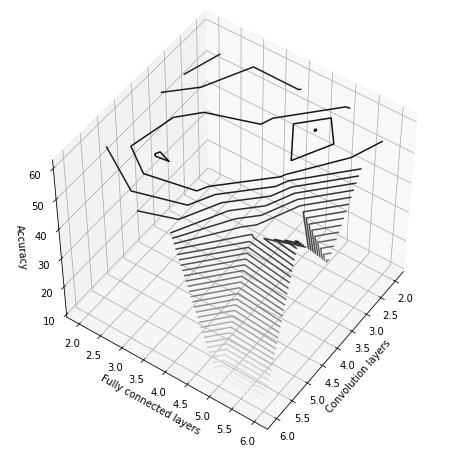

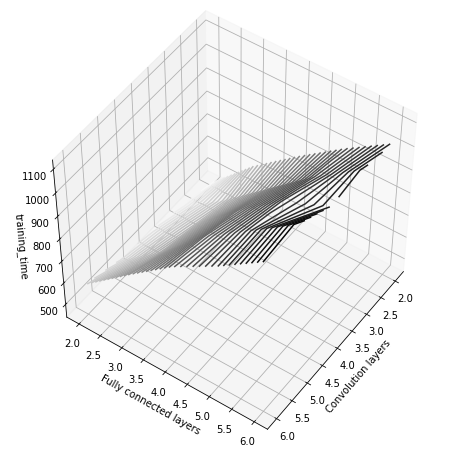

In [ ]:
# 1 will take a lot of time to be computed we have result already available to us
conv_layer_nums = [2,3,4,5,6]
fc_layer_nums = [2,3,4,5,6]
accuracy = [[55.04, 55.6, 58.25, 57.28, 55.58],
            [56.96, 58.29, 58.65, 60.14, 56.06],
            [56.95, 58.2, 59.43, 59.61, 54.12],
            [58.45, 61.58, 59.5, 49.03, 10.0],
            [59.02, 57.53, 36.69, 55.93, 10.0]]
training_time = [[453, 487, 517, 536, 581],
                 [631, 618, 648, 680, 733],
                 [774, 772, 822, 858, 878],
                 [906, 927, 966, 989, 989],
                 [1025, 1056, 1048, 1124, 1117]]
conv_layer_nums1, fc_layer_nums1 = np.meshgrid(conv_layer_nums, fc_layer_nums)
plotAccuracy3d(conv_layer_nums1, fc_layer_nums1, accuracy)
plotAccuracy3d(conv_layer_nums, fc_layer_nums, training_time, zlabel='training_time')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/3], Step [2000/5000], Loss: 1.9070
Epoch [1/3], Step [4000/5000], Loss: 1.7320
Epoch [2/3], Step [2000/5000], Loss: 1.2740
Epoch [2/3], Step [4000/5000], Loss: 1.4050
Epoch [3/3], Step [2000/5000], Loss: 1.3516
Epoch [3/3], Step [4000/5000], Loss: 0.8261
Finished Training
Accuracy of the network: 56.8 %
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/3], Step [2000/5000], Loss: 2.3059
Epoch [1/3], Step [4000/5000], Loss: 2.3130
Epoch [2/3], Step [2000/5000], Loss: 2.3058
Epoch [2/3], Step [4000/5000], Loss: 2.3092
Epoch [3/3], Step [2000/5000], Loss: 2.3111
Epoch [3/3], Step [4000/5000], Loss: 2.3107
Finished Training
Accuracy of the network: 10.0 %
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [1/3], Step [2000/5000], Loss: 1.3002
Epoch [1/3], Step [4000/5000], Loss: 1.2118
Epoch [2/3], Step [2000/5000], Loss: 1.6680
Epoch [2/3], Step [4000/5000], Loss: 1.6490
Epoch [3/3], Step [2000/5000], Loss: 1.5013
Epoch [3/3], Step [4000/5000], Loss: 0.9614
Finished Training
Accuracy of the network: 52.04 %
[56.8, 10.0, 52.04]


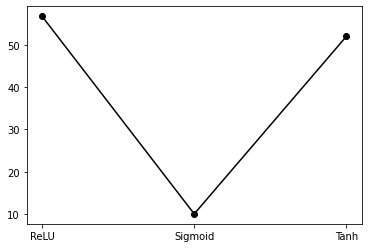

In [ ]:
# 2 Relu vs sigmoid vs tanh
activations = [F.relu, F.sigmoid, F.tanh]
accuracy = []
for activation in activations:
  acc, _ = train(2, 2, activation=activation, batch_size=10)
  accuracy.append(acc)

print(accuracy)
plt.plot(['ReLU', 'Sigmoid', 'Tanh'], accuracy,'ko-')

In [ ]:
# 3.1 With and without momentum
torch.manual_seed(1)
batch_size = 10
num_epochs = 5
without_momentum_accuracy, without_momentum_time = train(5,3, batch_size=batch_size, num_epochs=num_epochs,
                                                                               momentum=0)
print('\nwithout_momentum_accuracy: ', without_momentum_accuracy,
      'without_momentum_time', without_momentum_time)

momentum_accuracy, momentum_time = train(5,3, batch_size=batch_size, num_epochs=num_epochs,
                                                               momentum=0.5)
print('\nmomentum_accuracy: ', momentum_accuracy,
      'momentum_time', momentum_time)

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/5], Step [2000/5000], Loss: 2.3067
Epoch [1/5], Step [4000/5000], Loss: 2.2641
Epoch [2/5], Step [2000/5000], Loss: 1.5607
Epoch [2/5], Step [4000/5000], Loss: 1.4702
Epoch [3/5], Step [2000/5000], Loss: 1.3927
Epoch [3/5], Step [4000/5000], Loss: 1.6570
Epoch [4/5], Step [2000/5000], Loss: 1.5131
Epoch [4/5], Step [4000/5000], Loss: 1.2522
Epoch [5/5], Step [2000/5000], Loss: 1.3577
Epoch [5/5], Step [4000/5000], Loss: 1.5271
Finished Training
Accuracy of the network: 49.17 %

momentum_accuracy:  49.17 momentum_time 105


In [ ]:
# 3.2 With and without adaptive learning rate
torch.manual_seed(1)
batch_size = 10
num_epochs = 5
without_adaptivelr_accuracy, without_adaptivelr_time = train(5,3, batch_size=batch_size, num_epochs=num_epochs,
                                                             optimizer_func=1)
print('\without_adaptivelr_accuracy: ', without_adaptivelr_accuracy,
      'without_adaptivelr_time', without_adaptivelr_time)

adaptivelr_accuracy, adaptivelr_time = train(5,3, batch_size=batch_size, num_epochs=num_epochs,
                                             optimizer_func=2)
print('\n adaptivelr_accuracy: ', adaptivelr_accuracy,
      'adaptivelr_time', adaptivelr_time)

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/5], Step [2000/5000], Loss: 2.3066
Epoch [1/5], Step [4000/5000], Loss: 2.2651
Epoch [2/5], Step [2000/5000], Loss: 1.5498
Epoch [2/5], Step [4000/5000], Loss: 1.4514
Epoch [3/5], Step [2000/5000], Loss: 1.5012
Epoch [3/5], Step [4000/5000], Loss: 1.8537
Epoch [4/5], Step [2000/5000], Loss: 1.5930
Epoch [4/5], Step [4000/5000], Loss: 1.3068
Epoch [5/5], Step [2000/5000], Loss: 1.3149
Epoch [5/5], Step [4000/5000], Loss: 1.5115
Finished Training
Accuracy of the network: 51.24 %
\without_adaptivelr_accuracy:  51.24 without_adaptivelr_time 103
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/5], Step [2000/5000], Loss: 2.0897
Epoch [1/5], Step [4000/5000], Loss: 1.4233
Epoch [2/5], Step [2000/5000], Loss: 1.6834
Epoch [2/5], Step [4000/5000], Loss: 2.1181
Epoch [3/5], Step [2000/5000], Loss: 1.1168
Epoch [3/5], Step [4000/5000], Loss: 1.0925
Epoch [4/5], Step [2000/5000

In [ ]:
# 4. With and without Batch Normalization
torch.manual_seed(1)
batch_size = 10
num_epochs = 5
without_batch_normalization_accuracy, without_batch_normalization_time = train(5,3, batch_normalization=False,
                                                                               batch_size=batch_size, num_epochs=num_epochs)
print('\nwithout_batch_normalization_accuracy: ', without_batch_normalization_accuracy,
      'without_batch_normalization_time', without_batch_normalization_time)

batch_normalization_accuracy, batch_normalization_time = train(5,3, batch_normalization=True,
                                                               batch_size=batch_size, num_epochs=num_epochs)
print('\nbatch_normalization_accuracy: ', batch_normalization_accuracy,
      'batch_normalization_time', batch_normalization_time)

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/5], Step [2000/5000], Loss: 2.1246
Epoch [1/5], Step [4000/5000], Loss: 1.2830
Epoch [2/5], Step [2000/5000], Loss: 1.6756
Epoch [2/5], Step [4000/5000], Loss: 1.4634
Epoch [3/5], Step [2000/5000], Loss: 1.3908
Epoch [3/5], Step [4000/5000], Loss: 1.4308
Epoch [4/5], Step [2000/5000], Loss: 1.4543
Epoch [4/5], Step [4000/5000], Loss: 1.6950
Epoch [5/5], Step [2000/5000], Loss: 1.5386
Epoch [5/5], Step [4000/5000], Loss: 1.6865
Finished Training
Accuracy of the network: 43.99 %

without_batch_normalization_accuracy:  43.99 without_batch_normalization_time 111
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/5], Step [2000/5000], Loss: 1.6894
Epoch [1/5], Step [4000/5000], Loss: 1.0125
Epoch [2/5], Step [2000/5000], Loss: 1.1649
Epoch [2/5], Step [4000/5000], Loss: 1.9793
Epoch [3/5], Step [2000/5000], Loss: 1.3357
Epoch [3/5], Step [4000/5000], Loss: 1.4408
Epoch [4/5

In [4]:
# 5. Final architecture
torch.manual_seed(1)
batch_size = 100
num_epochs = 15
accuracy, ttime = train(7, 3, batch_size=batch_size,
                        num_epochs=num_epochs, optimizer_func=2,
                        batch_normalization=True, momentum=0, loss_threshold=0.0005,
                        debug_steps=400)
print('\naccuracy: ', accuracy, 'ttime', ttime)

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/15], Step [400/500], Loss: 1.1511
Epoch [2/15], Step [400/500], Loss: 0.9357
Epoch [3/15], Step [400/500], Loss: 0.7689
Epoch [4/15], Step [400/500], Loss: 0.5503
Epoch [5/15], Step [400/500], Loss: 0.3700
Epoch [6/15], Step [400/500], Loss: 0.4134
Epoch [7/15], Step [400/500], Loss: 0.5089
Epoch [8/15], Step [400/500], Loss: 0.3997
Epoch [9/15], Step [400/500], Loss: 0.2314
Epoch [10/15], Step [400/500], Loss: 0.2118
Epoch [11/15], Step [400/500], Loss: 0.2756
Epoch [12/15], Step [400/500], Loss: 0.1125
Epoch [13/15], Step [400/500], Loss: 0.0758
Epoch [14/15], Step [400/500], Loss: 0.1039
Epoch [15/15], Step [400/500], Loss: 0.0106
Finished Training
Accuracy of the network: 81.79 %

accuracy:  81.79 ttime 2129
